# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

In [113]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

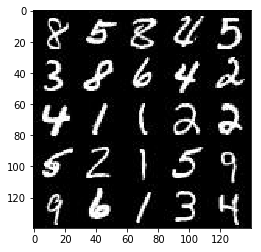

In [114]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

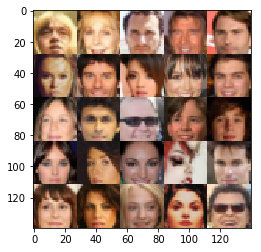

In [115]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [116]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [117]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, (), name="learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [149]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        depth = 128
        x = tf.layers.conv2d(images, depth, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x) # leaky relu
        # 14x14xdepth
        
        depth = depth * 2
        x = tf.layers.conv2d(x, depth, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x) # leaky relu
        # 7x7xdepth
        
        flat = tf.reshape(x, (-1, 7*7*depth))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [150]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        depth = 256
        x = tf.layers.dense(z, 7*7*depth, activation=None)
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 7, 7, depth))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x) # leaky relu
        # 7x7xdepth now
        
        depth = int(depth/2)
        x = tf.layers.conv2d_transpose(x, depth, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x) # leaky relu
        # 14x14xdepth now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [151]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smooth = 0.1 # Label smoothing
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [152]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Because I use tf.layers.batch_normalization
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [153]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [154]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10 # Show discrimator and generator loss every x steps
    show_every = 100 # Show the generator output every x steps
    n_images = 25 # The number of images to display
    losses = []
    steps = 0
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2 # Rescale between -1 and 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses

In [155]:
def plotLosses(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 2.5544
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 0.7056... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 0.7803... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 2.7418
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 1.0585
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.4876


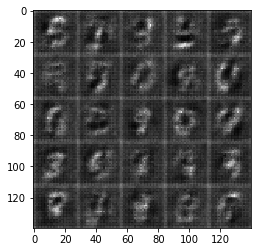

Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.8310
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 2.5418
Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.4965
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 0.9129... Generator Loss: 1.2446
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 1.7942
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 1.9089
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.9220


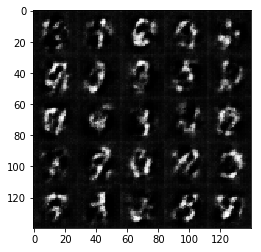

Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.8137
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.4837


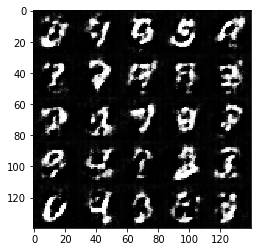

Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.0748
Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.2894
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 0.9536
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 0.8322... Generator Loss: 1.5137
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.3390
Epoch 1/2... Discriminator Loss: 0.9283... Generator Loss: 0.9792


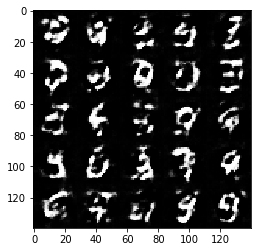

Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 0.7599... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 0.8388... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 0.7050... Generator Loss: 1.5924
Epoch 1/2... Discriminator Loss: 0.7202... Generator Loss: 1.8558
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 2.2915
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 1.2537
Epoch 1/2... Discriminator Loss: 0.9117... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 2.4422


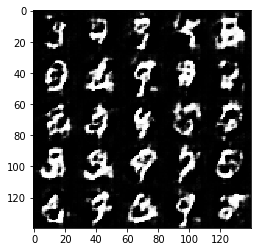

Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.3475
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 0.7964... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 0.8586... Generator Loss: 2.0605
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 1.1223
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.6460
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 2.2426
Epoch 1/2... Discriminator Loss: 0.7150... Generator Loss: 1.4879
Epoch 1/2... Discriminator Loss: 0.7314... Generator Loss: 1.6177
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.1859


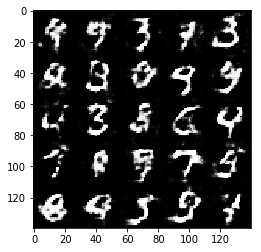

Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 2.2164
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 0.8153... Generator Loss: 1.8004
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.3361
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 0.7287... Generator Loss: 1.7766
Epoch 1/2... Discriminator Loss: 0.7427... Generator Loss: 1.3779


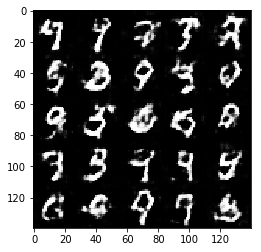

Epoch 1/2... Discriminator Loss: 0.7957... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.4476
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 1.3418
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.9614
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 0.8225... Generator Loss: 1.2346


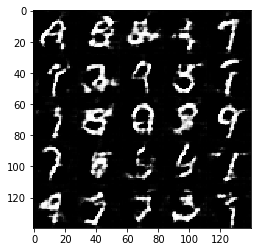

Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.7891
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 1.3441
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.5533
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 0.9835
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.0102... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 1.1012... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 0.9699... Generator Loss: 1.0007


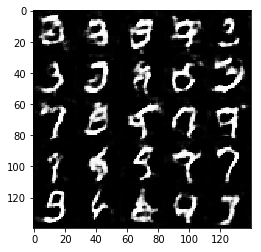

Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 1.3745
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 0.8998
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 2.0429
Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 1.5621
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 2.1943
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.8031
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 1.4344


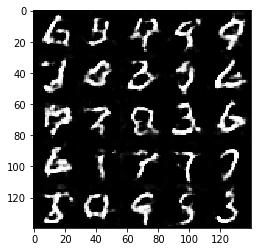

Epoch 1/2... Discriminator Loss: 0.9714... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.8654
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 1.2836
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.5387
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.3162
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 1.5423
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.4956


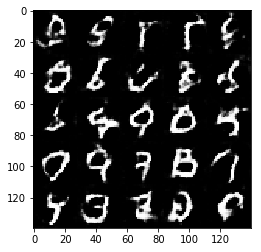

Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 1.4432
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.7404
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 2.0518
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 2.1659
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.2336
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 1.2072
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 0.8430


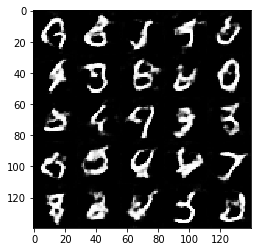

Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 2.4410
Epoch 1/2... Discriminator Loss: 0.8828... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.5644
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.4215
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 1.1911


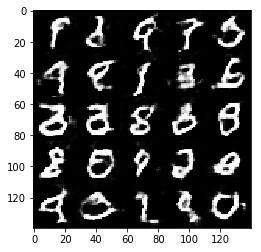

Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.2797... Generator Loss: 2.2965
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.8933


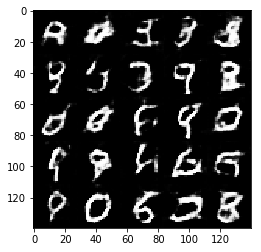

Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.8303
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 1.2860
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 0.8377... Generator Loss: 1.4325
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 0.9022
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 1.2076
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.2932


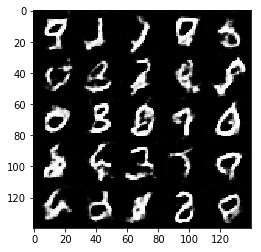

Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 1.1629
Epoch 1/2... Discriminator Loss: 1.0072... Generator Loss: 2.0182
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.2954
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.0700
Epoch 1/2... Discriminator Loss: 0.9154... Generator Loss: 1.4360
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.0703


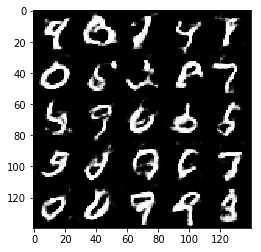

Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.1643
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.6124
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.4352
Epoch 1/2... Discriminator Loss: 0.8987... Generator Loss: 1.5556
Epoch 1/2... Discriminator Loss: 0.8234... Generator Loss: 1.2012
Epoch 1/2... Discriminator Loss: 1.0096... Generator Loss: 2.2142
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 1.2463
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 1.1128
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.2205


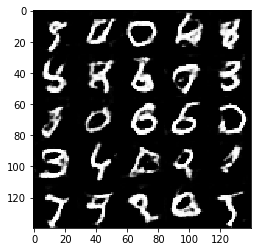

Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.5229
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.4039
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 1.7742
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.1282
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.8305


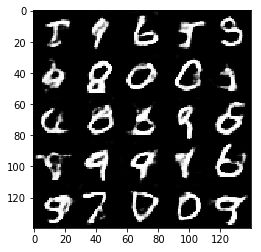

Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.2368
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 1.2393
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 2.5741
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 0.8993


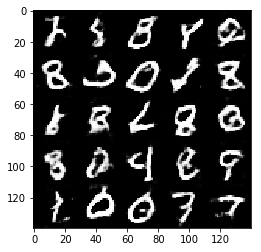

Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.5815
Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.7659
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.4692
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.2433
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.4164


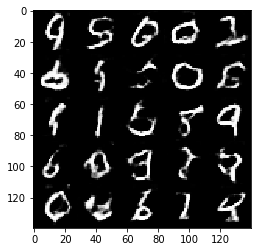

Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.8671
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.7564
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 2.4136
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.7100
Epoch 2/2... Discriminator Loss: 0.9896... Generator Loss: 2.6514
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.6708
Epoch 2/2... Discriminator Loss: 0.8172... Generator Loss: 1.3175
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.9635


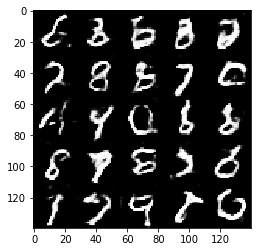

Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.9605
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.9271
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 0.8573... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.6365
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.7808
Epoch 2/2... Discriminator Loss: 1.0598... Generator Loss: 0.8761


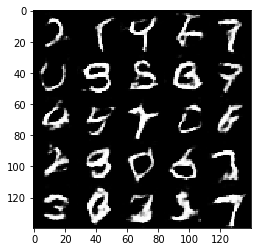

Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.1624
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 2.8224
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 1.4836
Epoch 2/2... Discriminator Loss: 0.8161... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.0844
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.0975
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 1.4052


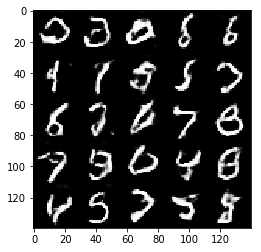

Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.3258
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.5751
Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.2821
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.6106... Generator Loss: 0.4603
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 1.0481
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 1.4347
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.0686


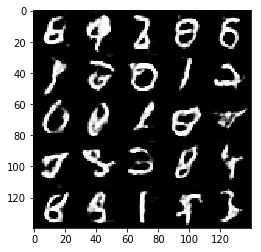

Epoch 2/2... Discriminator Loss: 1.6416... Generator Loss: 0.4064
Epoch 2/2... Discriminator Loss: 0.7355... Generator Loss: 1.4513
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.3812
Epoch 2/2... Discriminator Loss: 0.7418... Generator Loss: 1.4247
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.9345
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.1747
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.6724
Epoch 2/2... Discriminator Loss: 0.7967... Generator Loss: 1.4993
Epoch 2/2... Discriminator Loss: 0.7999... Generator Loss: 1.4608


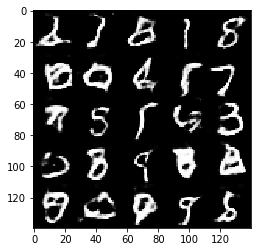

Epoch 2/2... Discriminator Loss: 0.8649... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.2306
Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 1.3597... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 0.7068... Generator Loss: 1.5574
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.8883... Generator Loss: 1.0541
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.4531


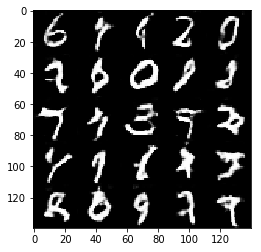

Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.1673
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.6277
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 3.2873
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 2.6668
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.3222
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.3806
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 2.0795


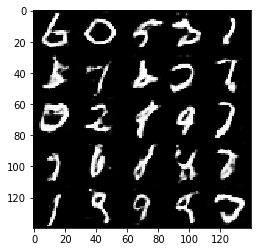

Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 1.3892
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.1345
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 1.8903
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 2.1531
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 1.4451
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 0.8631... Generator Loss: 1.0628
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 0.9721


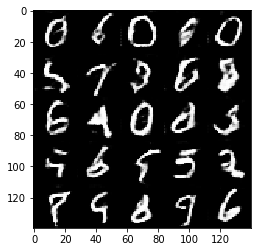

Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 1.3843
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 1.0824... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.7292
Epoch 2/2... Discriminator Loss: 0.8451... Generator Loss: 1.4987
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 1.6750... Generator Loss: 2.7355
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.6321


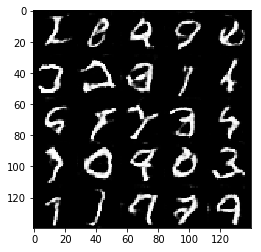

Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 1.9027
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.7235
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 0.8276... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.6814
Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 1.0598
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 1.1094
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.1706
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.4304
Epoch 2/2... Discriminator Loss: 0.6928... Generator Loss: 1.4168


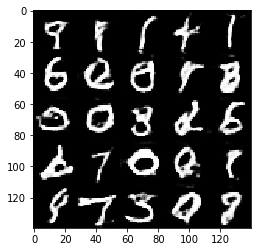

Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 1.2002
Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.7267
Epoch 2/2... Discriminator Loss: 0.7850... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 0.6263... Generator Loss: 1.8748
Epoch 2/2... Discriminator Loss: 4.2444... Generator Loss: 5.5132
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 0.8361
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.6062
Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.2683


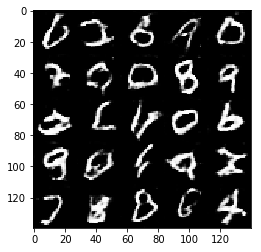

Epoch 2/2... Discriminator Loss: 0.7511... Generator Loss: 1.5500
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 2.3668
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.0158
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.2656
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 1.8143
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 0.7568... Generator Loss: 1.3566
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.7132
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 2.2563


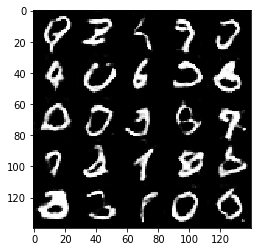

Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 2.3562
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.8558
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 2.3628
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 2.1961
Epoch 2/2... Discriminator Loss: 0.6806... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.0007
Epoch 2/2... Discriminator Loss: 0.6991... Generator Loss: 1.4903
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 2.6364
Epoch 2/2... Discriminator Loss: 0.7150... Generator Loss: 1.5519


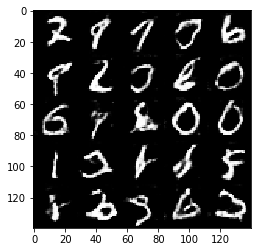

Epoch 2/2... Discriminator Loss: 0.8147... Generator Loss: 1.1635
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 2.0574
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.3627
Epoch 2/2... Discriminator Loss: 0.7289... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 1.3252
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 2.5699
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 2.4553
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.2191


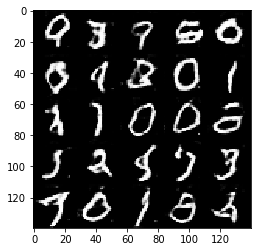

Epoch 2/2... Discriminator Loss: 0.7952... Generator Loss: 1.3628
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.0901
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.2653
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 0.8225... Generator Loss: 1.1226
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.3238
Epoch 2/2... Discriminator Loss: 0.6448... Generator Loss: 1.8130
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.8975
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 2.0840


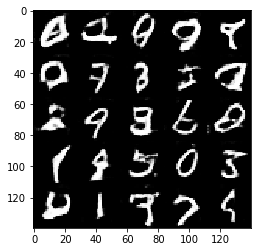

Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.6986
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.7375
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.4512
Epoch 2/2... Discriminator Loss: 0.6745... Generator Loss: 1.4918
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.8012
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 1.2112
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.5871
Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 1.0760


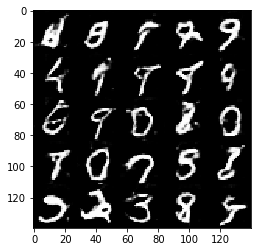

Epoch 2/2... Discriminator Loss: 0.6506... Generator Loss: 1.8087
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.3849
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 2.0460
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 2.2115
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.5690
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.3746
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.2851


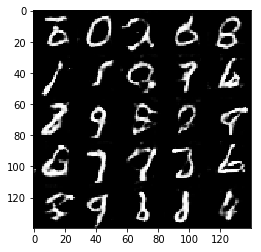

Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 2.7866
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.3075
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.7606
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.6388
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 1.7213


In [156]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, 
                   mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

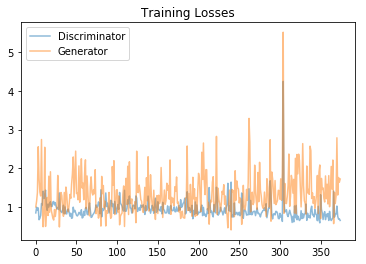

In [157]:
plotLosses(losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [158]:
print(celeba_dataset.shape)

(202599, 28, 28, 3)


Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 1.0456
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 1.9686
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.5459
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.9703
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 3.0698
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.9571


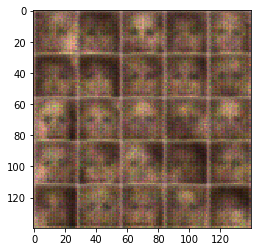

Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.8834
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.8211
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 2.1355
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.7959


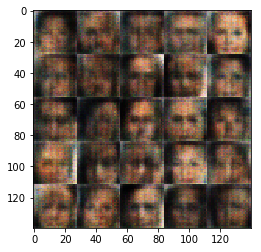

Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.4513
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.2516


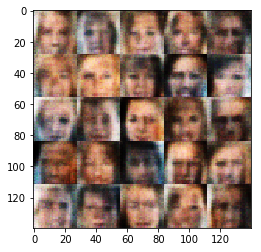

Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 2.1728
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.5528
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 2.2256
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 1.6722


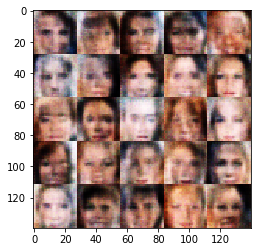

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.1745
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 2.0397... Generator Loss: 3.2866
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2319


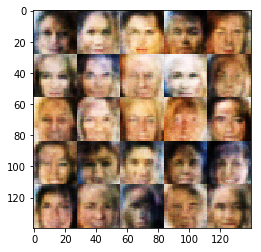

Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.7262
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.0395
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 0.6945... Generator Loss: 1.7647
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.8538... Generator Loss: 3.1276
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.2339


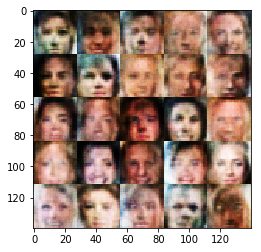

Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 1.5972
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.0660
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.0250


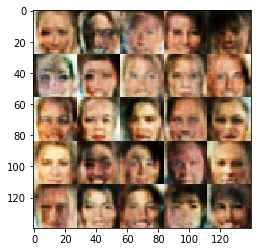

Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.6974


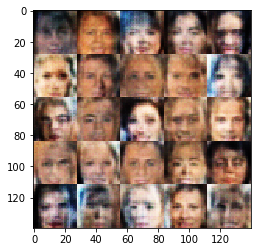

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.0218
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.6505
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7401


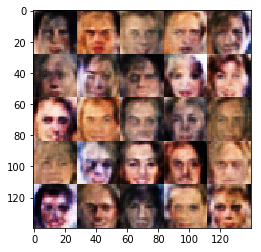

Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.8115


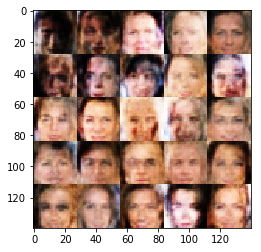

Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.9679


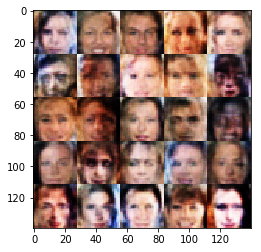

Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.3706
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 1.1759
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.6331
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.4209
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7659


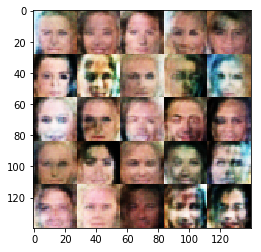

Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.0657
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.8178
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.0564


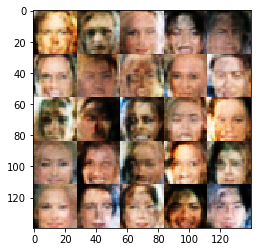

Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.4035
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.8369
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8160


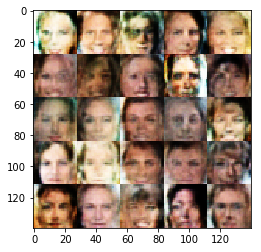

Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.7021


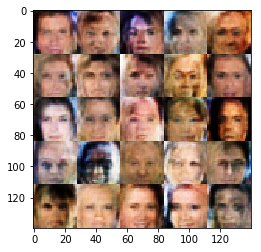

Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.9269
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.8542
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 2.0922... Generator Loss: 0.2317


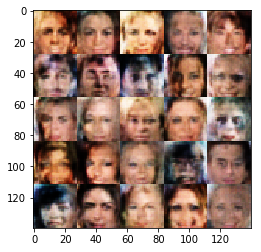

Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.9103
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.6661
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 1.3913
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.4917


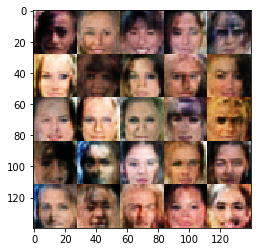

Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.9671
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 2.7502
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 3.4224
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 2.7187
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.2640


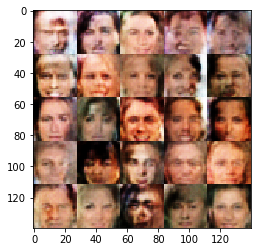

Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.5574
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.3533
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 3.0694
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 3.9681


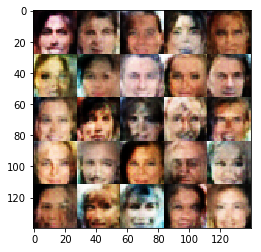

Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 1.3334
Epoch 1/1... Discriminator Loss: 0.5634... Generator Loss: 2.1577
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 2.4947
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 3.6592
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 3.7752
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 2.2204
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 3.5601
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 3.4149


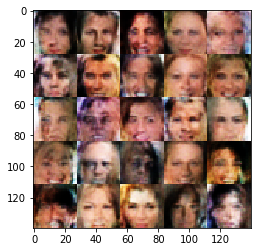

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 3.2389
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 2.5575
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 3.2987
Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.2271
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 2.7432
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 3.6215
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.2272


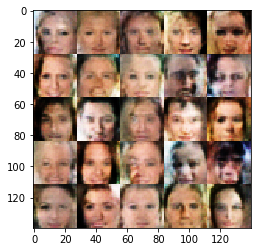

Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 2.8611
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 3.4414
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.8799
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.5565
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 5.2965
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 3.1788
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.6506
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 2.7153
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.8130


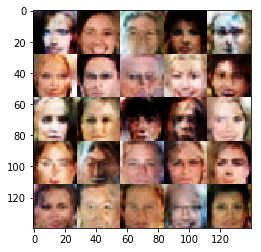

Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.7360
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.2359
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 2.8964
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 4.1176
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5062


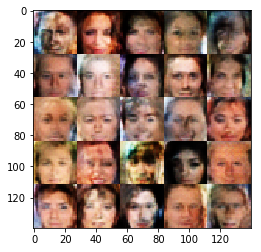

Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 2.3827
Epoch 1/1... Discriminator Loss: 0.4007... Generator Loss: 3.8098
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 0.9925


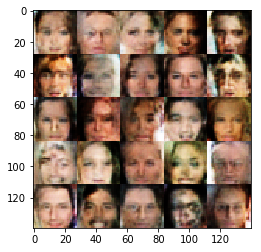

Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 4.2318
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 2.4163
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.7987
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 2.5571
Epoch 1/1... Discriminator Loss: 0.4955... Generator Loss: 2.7562
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.4992
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.9003
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.3481


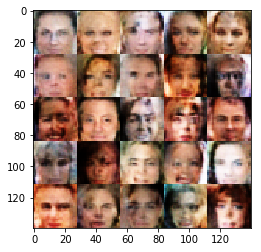

Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 4.7533
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 4.9354
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 3.7233
Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 2.9292
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 5.4565
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 2.6302
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 0.5294... Generator Loss: 2.1868
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 3.7455


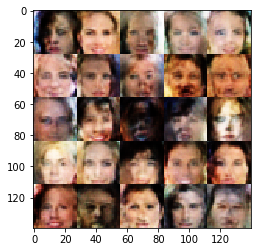

Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.6081
Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 5.1385
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.7105
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.6982
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 3.0962
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.4097... Generator Loss: 3.5932
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 2.7565
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 5.0714


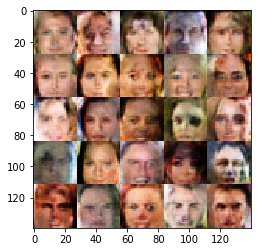

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.4212
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 2.0485
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 6.5049
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 4.9458
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 3.9280
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.6842
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 3.6278


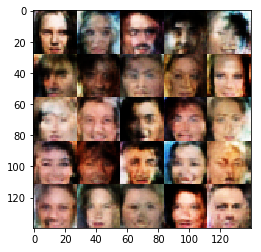

Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 5.0321
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 3.1363
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 7.0441
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.2002
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 4.7549
Epoch 1/1... Discriminator Loss: 0.5164... Generator Loss: 2.5404
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 2.5733
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 2.0183
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.7861
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.5994


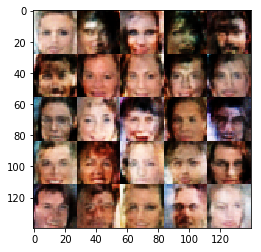

Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 5.9331
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 5.6151
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.6895
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 3.2030
Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 3.9937
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 6.2334


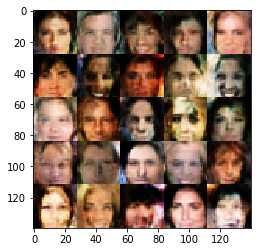

Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 6.1484
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 5.4012
Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 4.1440
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 2.7512
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 3.1727
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 4.2536
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 2.5642
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 3.6271
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 3.8884


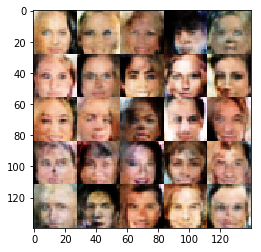

Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 0.3526... Generator Loss: 4.9844
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 3.3711
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 2.1993
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 4.4199
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 3.6358
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.6490
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.7338
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 3.1189
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.5832


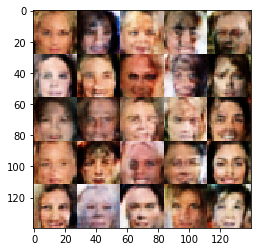

Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 3.1344
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 5.2466
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 3.8973
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 3.2543
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 2.8812
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 3.3491


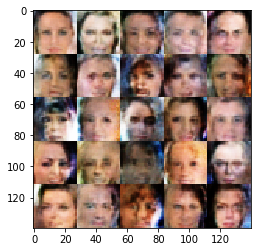

Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 7.0854
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 2.7268
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 6.3934
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 3.5566
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 4.4924
Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 3.6749
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 6.0616
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 3.1562
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 4.1268


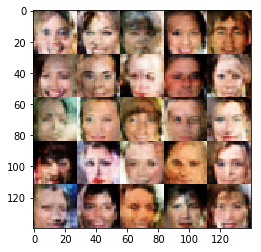

Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.7701
Epoch 1/1... Discriminator Loss: 0.4906... Generator Loss: 4.4039
Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 6.5006
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 6.4648
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 3.9785
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 3.0935
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 4.5568
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.6032


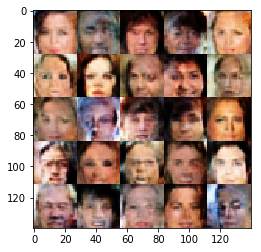

Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 4.3237
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 4.2811
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 4.2553
Epoch 1/1... Discriminator Loss: 0.6786... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.4985
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.7610
Epoch 1/1... Discriminator Loss: 0.5065... Generator Loss: 3.6907


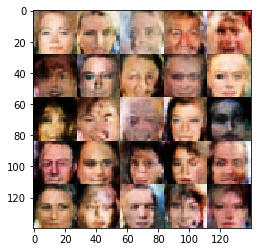

Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 3.2264
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 1.5523
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 4.6603
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 3.6454
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 4.4063
Epoch 1/1... Discriminator Loss: 0.6332... Generator Loss: 4.5592


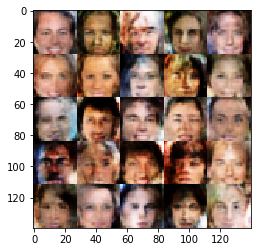

Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.3401
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 2.5840
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 4.6434
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 4.9109
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.2400
Epoch 1/1... Discriminator Loss: 0.4997... Generator Loss: 3.0814
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.7673


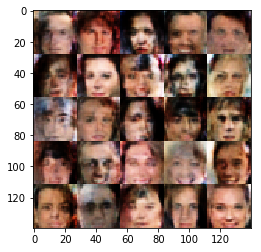

Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 4.8950
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 3.2636
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 3.5938
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 3.4940
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 7.0065
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 3.3331
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 4.3290
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 3.6713
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 8.9306


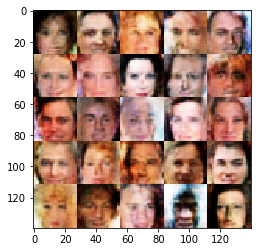

Epoch 1/1... Discriminator Loss: 0.5213... Generator Loss: 4.6935
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 4.3313
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 5.8854
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.6503
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 3.0804
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 3.5884
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 3.3340
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 6.0099


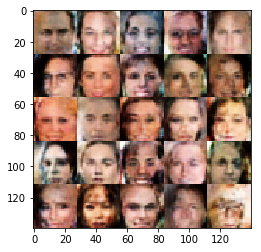

Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 5.3167
Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.5607
Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 5.6989
Epoch 1/1... Discriminator Loss: 0.7813... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 5.3692
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 4.9504
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 3.0396
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.5613
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.9557


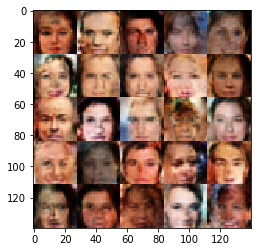

Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.6418
Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 2.3635
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.1800
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 4.1025
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 2.5314
Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 4.3961
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.6827
Epoch 1/1... Discriminator Loss: 0.4142... Generator Loss: 5.0656
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 5.0080


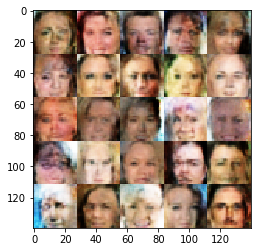

Epoch 1/1... Discriminator Loss: 2.1027... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.4286
Epoch 1/1... Discriminator Loss: 0.5994... Generator Loss: 1.9460
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.7763
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 3.5817
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 2.9818
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.5235
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.2555
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 3.3907
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 2.4290


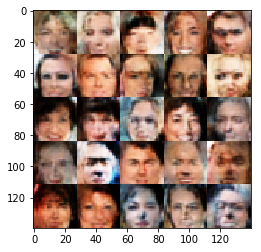

Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 2.7064
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 5.2739
Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 3.7898
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.7410
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 3.1670
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8447


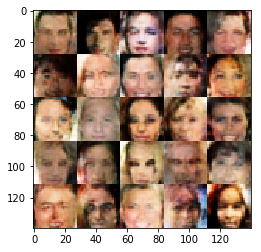

Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.7226
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 5.1199
Epoch 1/1... Discriminator Loss: 0.6194... Generator Loss: 2.7663
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 4.3870
Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 2.4837
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.8576
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.7226
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 3.4537


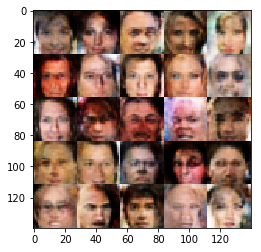

Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 0.4878... Generator Loss: 2.3633
Epoch 1/1... Discriminator Loss: 0.4691... Generator Loss: 3.0411
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 3.1359
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 3.5915
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 3.3880
Epoch 1/1... Discriminator Loss: 0.6110... Generator Loss: 2.2009
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 3.1349
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.5865... Generator Loss: 4.9720


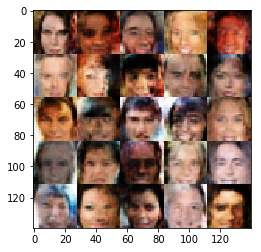

Epoch 1/1... Discriminator Loss: 0.4755... Generator Loss: 2.8983
Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 4.6737
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 2.6475
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.2086
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 3.3799
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.8466
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 4.0139
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 2.0831
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.3499


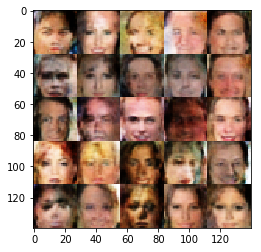

Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 3.7272
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 4.5456
Epoch 1/1... Discriminator Loss: 0.7127... Generator Loss: 1.9371
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.5445
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 5.0741
Epoch 1/1... Discriminator Loss: 0.6606... Generator Loss: 2.6414
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 3.7208
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 3.0136


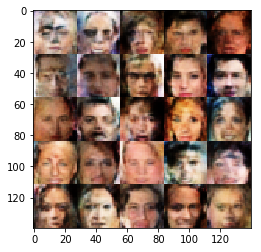

Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 2.6846
Epoch 1/1... Discriminator Loss: 0.4784... Generator Loss: 2.6657
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.6685
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 2.2771
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 2.3198
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 3.1324
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 3.9218
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 3.0114
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 3.1766


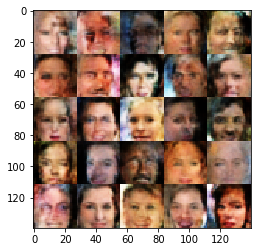

Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.9150
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 3.0143
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 4.1992
Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 2.0014
Epoch 1/1... Discriminator Loss: 0.5572... Generator Loss: 3.8504
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 3.8891
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.1102
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 4.4466
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 2.7802


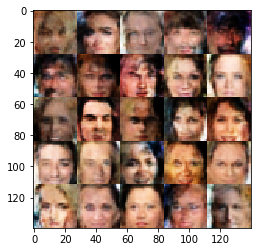

Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 5.8475
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.6039
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 3.6652
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.6201
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 2.5904
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.8218


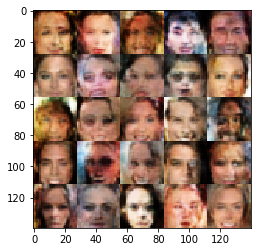

Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.7258
Epoch 1/1... Discriminator Loss: 0.5211... Generator Loss: 2.8903
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 0.4321... Generator Loss: 3.7541
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 2.3542
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.8139
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.2979
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 2.8289
Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.6036
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.9056


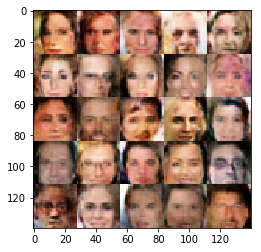

Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.7843
Epoch 1/1... Discriminator Loss: 0.6328... Generator Loss: 1.9055
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 3.4465
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.9712
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 0.5523... Generator Loss: 2.3052
Epoch 1/1... Discriminator Loss: 0.6076... Generator Loss: 2.1057
Epoch 1/1... Discriminator Loss: 0.4838... Generator Loss: 2.6872
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.7616


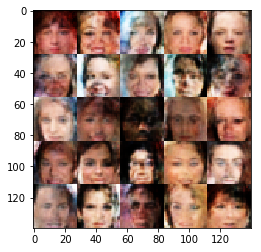

Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 2.3877
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 1.7676
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 2.1688
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.7739
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.4452
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 4.7748
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 2.1693


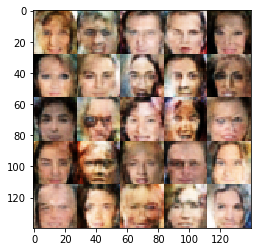

Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.4162... Generator Loss: 3.8381
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 3.7376
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 4.0491
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 3.3057
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.4269
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 2.5581
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 4.3910


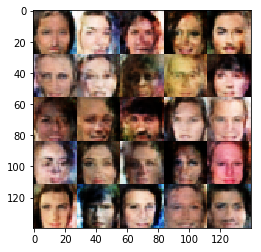

Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 2.6524
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.3421
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 0.5617... Generator Loss: 2.3834
Epoch 1/1... Discriminator Loss: 0.8885... Generator Loss: 4.0941
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 2.4610
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 2.1320
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 3.1610
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 4.5026
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 3.0787


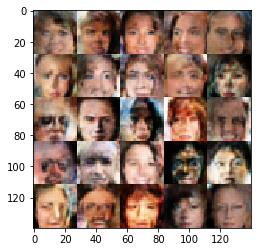

Epoch 1/1... Discriminator Loss: 1.9433... Generator Loss: 0.2730
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.7100
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 3.3724
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 3.7991
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 3.3575
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.8130
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.7852
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 3.4674


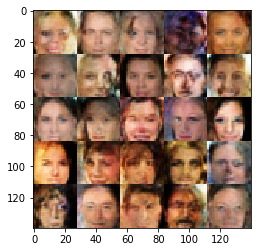

Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 1.7896
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.9343
Epoch 1/1... Discriminator Loss: 0.6580... Generator Loss: 3.5236
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.9744
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 4.8213
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 2.9181
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.8811


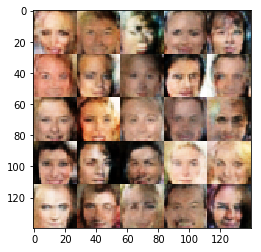

Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.9328
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 2.0039
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 2.7853
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 2.1725
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 3.3305
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.6732


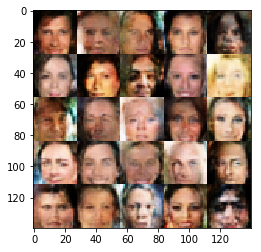

Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 2.5483
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 2.5035
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.5790
Epoch 1/1... Discriminator Loss: 0.5531... Generator Loss: 3.5332
Epoch 1/1... Discriminator Loss: 0.5396... Generator Loss: 5.5916
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.8474
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 2.4227
Epoch 1/1... Discriminator Loss: 0.6495... Generator Loss: 2.7033
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.6709


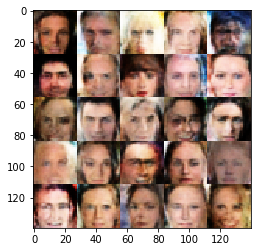

Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 4.6161
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 2.4748
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 2.2364
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 3.0319
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.3374
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.6767... Generator Loss: 1.9933


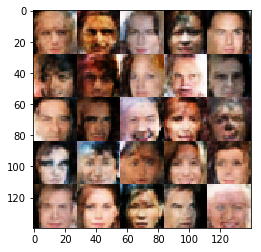

Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 3.4472
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 4.1528
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.8281
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 1.7725
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.4723
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 2.1653


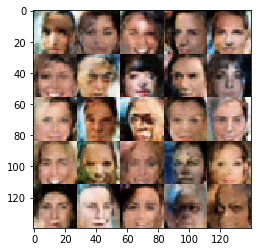

Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 2.1198
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.5498... Generator Loss: 2.4273
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.7758... Generator Loss: 3.2016
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.8984
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.6717


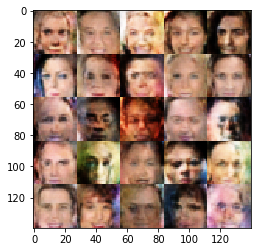

Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 5.0667
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 2.0358


In [161]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

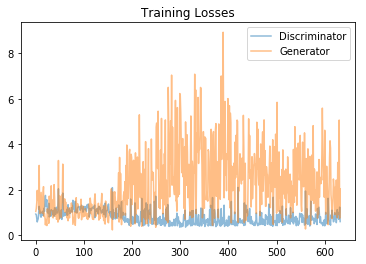

In [162]:
plotLosses(losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.